In [176]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras import layers
import tensorflow as tf
import time
from IPython.display import clear_output


In [177]:
BUFFER_SIZE = 60000
BATCH_SIZE = 40
DATASET_PATH = './Dataset/'

In [178]:
def image_generator(image_folder):
    for image_class in os.listdir(image_folder):
        class_path = f'{image_folder}/{image_class}'
        image_files = [f for f in os.listdir(class_path)]
        
    def preprocess_image(image_file):
        image_path = os.path.join(class_path, image_file)
        img = load_img(image_path, target_size=(28,28,1), color_mode='grayscale')
        img = img_to_array(img)
        img = (img - 127.5) / 127.5
        return img
    for image_file in image_files:
        yield preprocess_image(image_file)
        
train_dataset = tf.data.Dataset.from_generator(
    lambda:image_generator(DATASET_PATH),
    output_signature=tf.TensorSpec(shape=(28,28,1), dtype = tf.float32)
)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Generator

In [179]:
def generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7,7,256)),
        
        layers.Conv2DTranspose(128, kernel_size = (5, 5), strides = (1, 1), padding = 'same', use_bias = False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', use_bias = False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(16, kernel_size = (5, 5), strides = (1, 1), padding = 'same', use_bias = False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(1, kernel_size = (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='tanh')
    ])
    
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

d:\Apps\Conda\envs\TensorFlow\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


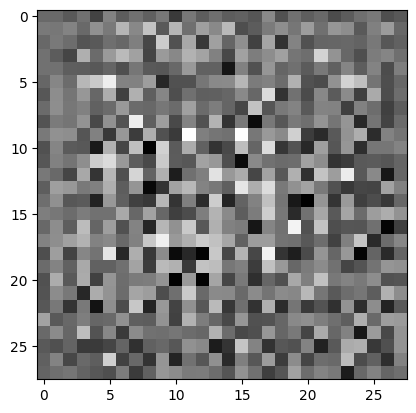

In [180]:
generator = generator_model()
noise = tf.random.normal([1,100])
generated_img = generator(noise, training=False)
plt.imshow(generated_img[0, :, :, 0], cmap='gray')

# Discriminator

In [181]:
def discriminator_model():
    model = tf.keras.Sequential([
        layers.Input((28, 28, 1)),
        layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [182]:
discriminator = discriminator_model()
confidence = discriminator(generated_img, training=False)
print(confidence)

tf.Tensor([[0.49983075]], shape=(1, 1), dtype=float32)


# Loss Function

In [183]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [184]:
def generator_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

In [185]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    
    return real_loss + fake_loss

In [186]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training

In [187]:
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLE_TO_SHOW = 16

seed = tf.random.normal([NUM_EXAMPLE_TO_SHOW, NOISE_DIM])


In [188]:
@tf.function
def training(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_image = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)
        
    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_dis = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_dis, discriminator.trainable_variables))

In [189]:
def generate_images(model, test_input):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(5,5))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [190]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            training(image_batch)
            
        clear_output(wait=True)
        generate_images(generator, seed)
        
        print(f'Epoch {epoch+1} - {time.time()-start} seconds')
    
    clear_output(wait=True)
    generate_images(generator, seed)

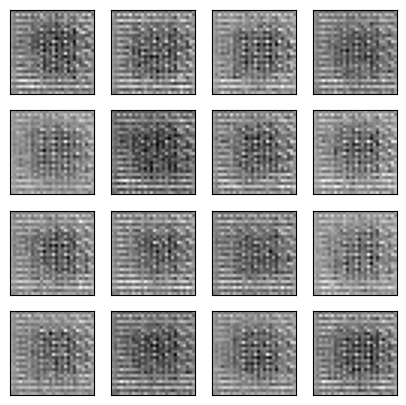

Epoch 1 - 10.51315450668335 seconds


KeyboardInterrupt: 

In [191]:
train(train_dataset, EPOCHS)